## Inicialización

## Visión por Computadora
Este notebook aborda la manipulación de datos aplicados a la visión por computadora. El objetivo es desarrollar un modelo de regresión capaz de estimar la edad de individuos a partir de imágenes faciales, utilizando aprendizaje profundo.

Las etapas incluyen:
1. Carga y preparación de datos;
2. Análisis exploratorio para comprender la distribución etaria;
3. Implementación y entrenamiento de un modelo basado en ResNet50;
4. Evaluación del modelo y análisis de resultados.

## Cargar los datos

El conjunto de datos contiene imágenes faciales asociadas a edades reales, almacenadas en la carpeta `/datasets/`. La estructura del conjunto de datos se compone de:

- **`final_files/`**: Directorio que contiene 7.6k imágenes faciales;
- **`labels.csv`**: Archivo CSV que contiene las etiquetas con dos columnas:
  - `file_name`: Nombre del archivo de imagen.
  - `real_age`: Edad real correspondiente a la imagen.

Dado el gran volumen de imágenes, es esencial utilizar un método eficiente para la carga. Se empleará `ImageDataGenerator` para evitar la carga simultánea de todas las imágenes en memoria, además de normalizar los valores de los píxeles, facilitando la convergencia del modelo.


In [1]:
# Importando las bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import inspect
import subprocess

In [2]:
# Cargando el archivo CSV con las etiquetas
labels_df = pd.read_csv('datasets/labels.csv')

# Mostrando la estructura del dataset
print("Estructura del conjunto de datos:")
print(labels_df.head(), "\n")
print("Resumen estadístico de las edades:")
print(labels_df['real_age'].describe())

# Configuración de ImageDataGenerator para normalización y particionamiento
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización de los píxeles
    validation_split=0.25  # 25% de los datos reservados para validación
)

# Creación de generadores de datos para entrenamiento y validación
train_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='datasets/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='datasets/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345
)

# Mostrando información sobre los lotes generados
images, ages = next(train_gen)
print("\nDimensiones de los lotes generados:")
print(f"Imágenes: {images.shape}, Edades: {ages.shape}")
print(f"Rango de valores de las imágenes: {images.min()} - {images.max()}")
print(f"Ejemplo de edades en el lote: {ages[:5]}")


Estructura del conjunto de datos:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17 

Resumen estadístico de las edades:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Dimensiones de los lotes generados:
Imágenes: (16, 224, 224, 3), Edades: (16,)
Rango de valores de las imágenes: 0.0 - 1.0
Ejemplo de edades en el lote: [27 19 27  6 47]


---
<b>Estructura del Conjunto de Datos:</b>
- Total de 7.591 registros en el archivo de etiquetas.
- Distribución entrenamiento/validación: 5.694/1.897 imágenes (proporción ~75%/25%).
- Rango de edades observado en la muestra inicial: 4-80 años.

<b>Resultados de lo realizado:</b>
- Imágenes redimensionadas a 224x224 píxeles con 3 canales (RGB).
- Normalización de píxeles aplicada (0-1).
- Tamaño de lote de 16 implementado correctamente.
- Datos estructurados adecuadamente para la tarea de regresión.

Ahora los datos han sido cargados y están correctamente preparados para el entrenamiento del modelo de detección de edad.

---

## Análisis Exploratorio de Datos (EDA)

El Análisis Exploratorio de Datos (EDA) permite comprender la distribución de las edades e identificar patrones relevantes que pueden afectar el rendimiento del modelo.

Los principales objetivos de este análisis son:
1. Verificar la distribución etaria en el conjunto de datos;
2. Identificar posibles desequilibrios entre grupos de edad;
3. Evaluar la presencia de valores atípicos (*outliers*);
4. Comprender características de los datos que pueden influir en la modelización.

---

Estadísticas descriptivas de las edades:

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


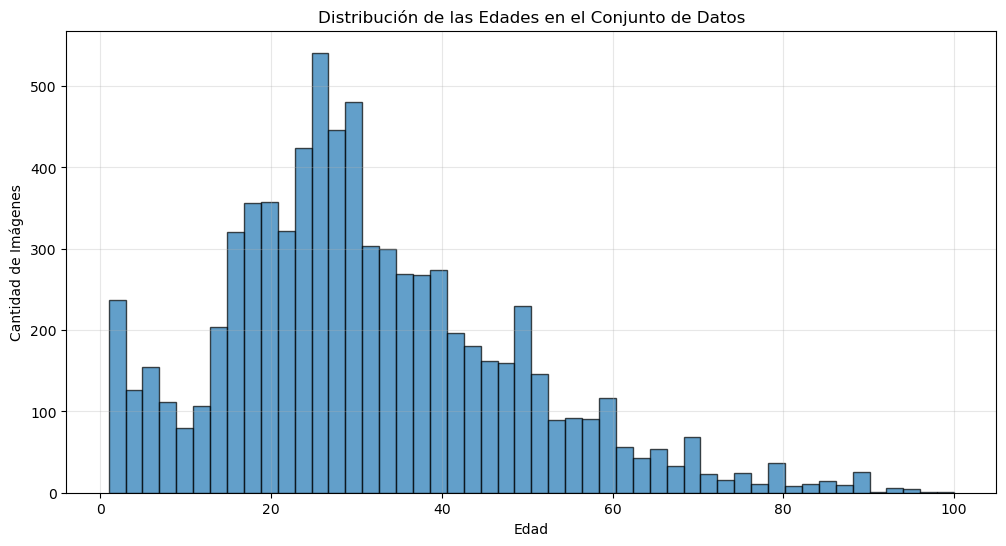

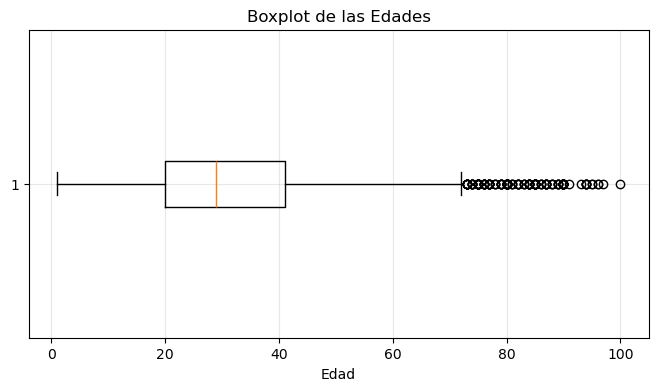

In [3]:
# Estadísticas descriptivas de las edades
print("Estadísticas descriptivas de las edades:\n")
print(labels_df['real_age'].describe())

# Visualización de la distribución etaria
plt.figure(figsize=(12, 6))
plt.hist(labels_df['real_age'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribución de las Edades en el Conjunto de Datos')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Imágenes')
plt.grid(True, alpha=0.3)
plt.show()

# Boxplot para identificar valores atípicos
plt.figure(figsize=(8, 4))
plt.boxplot(labels_df['real_age'], vert=False)
plt.title('Boxplot de las Edades')
plt.xlabel('Edad')
plt.grid(True, alpha=0.3)
plt.show()

### <b>Análisis Exploratorio de Datos</b>

#### <b>Distribución Etaria</b>
- **Mediana:** 29 años
- **Intervalo Intercuartil (IQR):** 21 años (Q1=20, Q3=41)
- **Asimetría:** Distribución sesgada positivamente (*right-skewed*), con una mayor concentración entre 20-40 años.

La asimetría en la distribución sugiere una mayor representación de adultos jóvenes y una menor presencia de individuos mayores en el conjunto de datos. Esto puede afectar la capacidad del modelo para predecir con precisión edades extremas.

---

#### <b>Implicaciones para el Modelo</b>

1. **Desbalance entre Grupos Etarios**  
   - Pico de observaciones entre 20-30 años (~2.000 imágenes).
   - Subrepresentación de edades mayores a 60 años.
   - El modelo puede tener menor precisión en edades extremas debido al sesgo del conjunto de datos.

2. **Consideraciones sobre la Aplicación**  
   - El conjunto de datos tiene una cantidad significativa de imágenes de menores de edad (<18 años), lo que puede ser ventajoso para tareas de verificación etaria.
   - Si el objetivo del modelo es diferenciar entre menores y adultos (ej: restricciones de venta de alcohol), el dataset está relativamente bien distribuido para este propósito.
   - Si se necesita una mejor representación de los extremos etarios, se pueden aplicar técnicas como *oversampling* o recopilación de datos adicionales.

A continuación, realizaremos un análisis más detallado de la distribución etaria, identificando patrones y ajustes necesarios para optimizar el entrenamiento del modelo.


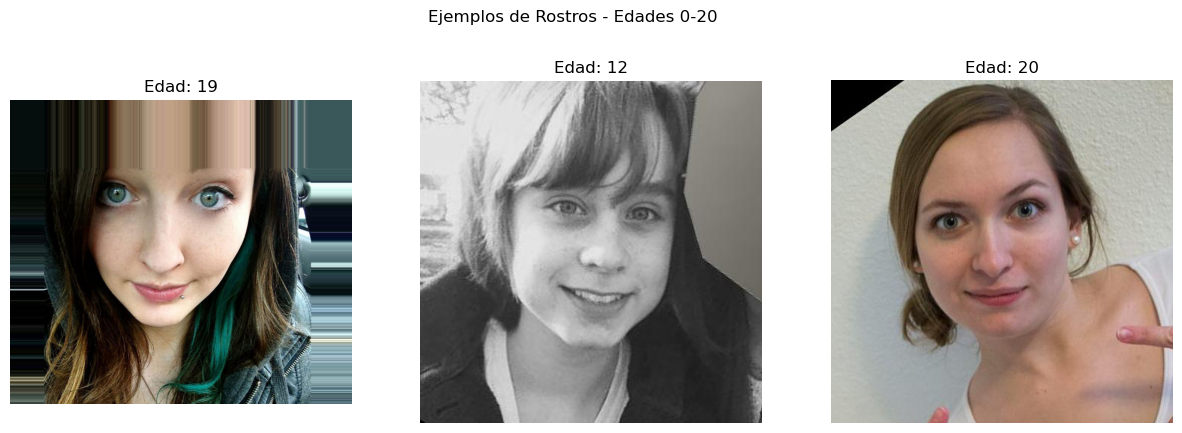

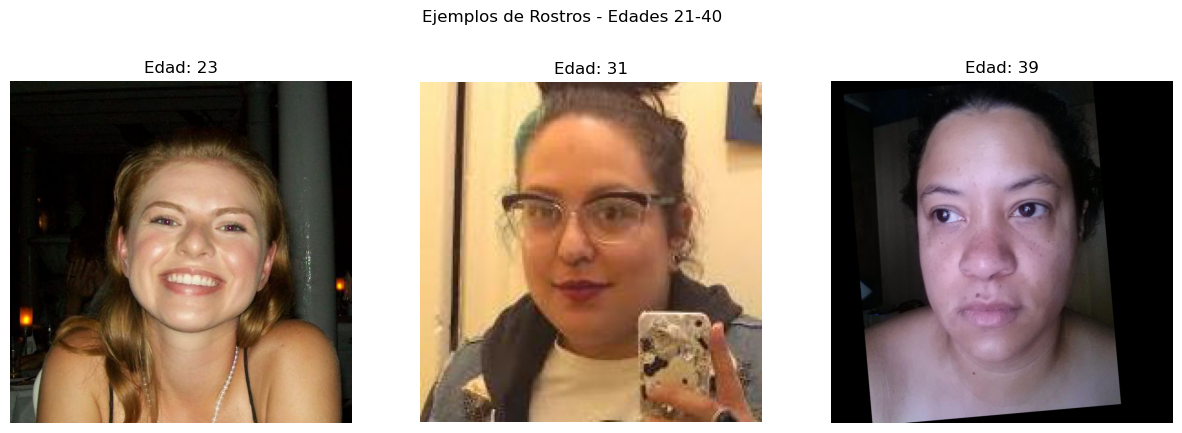

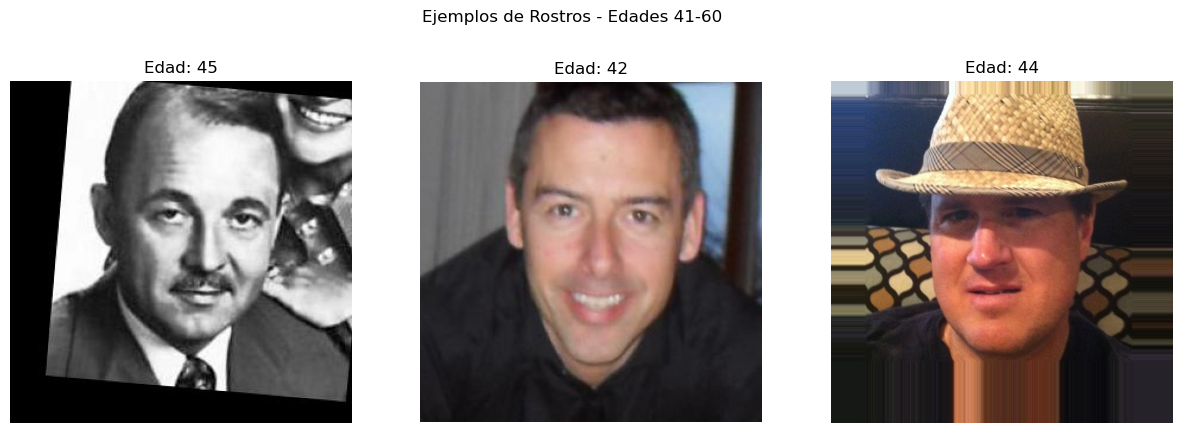

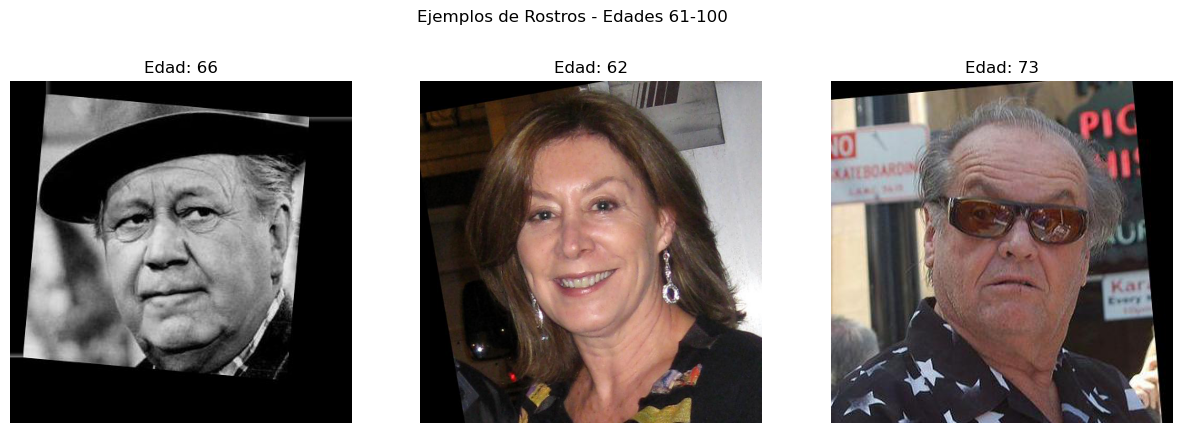

In [4]:
# Función para mostrar ejemplos de imágenes por rango de edad
def plot_examples_by_age(df, age_range, num_examples=3):
    samples = df[(df['real_age'] >= age_range[0]) & 
                 (df['real_age'] <= age_range[1])].sample(n=num_examples, random_state=42)

    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for idx, (_, row) in enumerate(samples.iterrows()):
        img_path = f"datasets/final_files/{row['file_name']}"
        img = plt.imread(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Edad: {row['real_age']}")
    plt.suptitle(f'Ejemplos de Rostros - Edades {age_range[0]}-{age_range[1]}')
    plt.show()

# Visualizar ejemplos de diferentes rangos de edad
age_ranges = [(0, 20), (21, 40), (41, 60), (61, 100)]
for age_range in age_ranges:
    plot_examples_by_age(labels_df, age_range)


### <b>Encontrando Patrones en la Distribución Etaria</b>

#### <b>Análisis para Verificación de Edad</b>

La distribución etaria del conjunto de datos es un factor crítico para la construcción de un modelo de regresión eficaz. Dado que el objetivo involucra la verificación etaria, especialmente para diferenciar menores de edad de adultos, es esencial comprender la representatividad de los diferentes grupos etarios en el conjunto de datos.

---

#### <b>Distribución por Grupos Etarios Relevantes</b>

Para una mejor interpretación de los datos, la variable `real_age` fue categorizada en grupos etarios específicos:

- **Menores de 18 años**
- **18 a 21 años**
- **22 a 25 años**
- **26 a 35 años**
- **36 a 50 años**
- **Mayores de 50 años**

Esto permite evaluar la distribución de los ejemplos de forma segmentada, facilitando la interpretación de los patrones etarios e identificando posibles desequilibrios que puedan afectar el rendimiento del modelo.



Verificación de valores ausentes:
file_name    0
real_age     0
dtype: int64


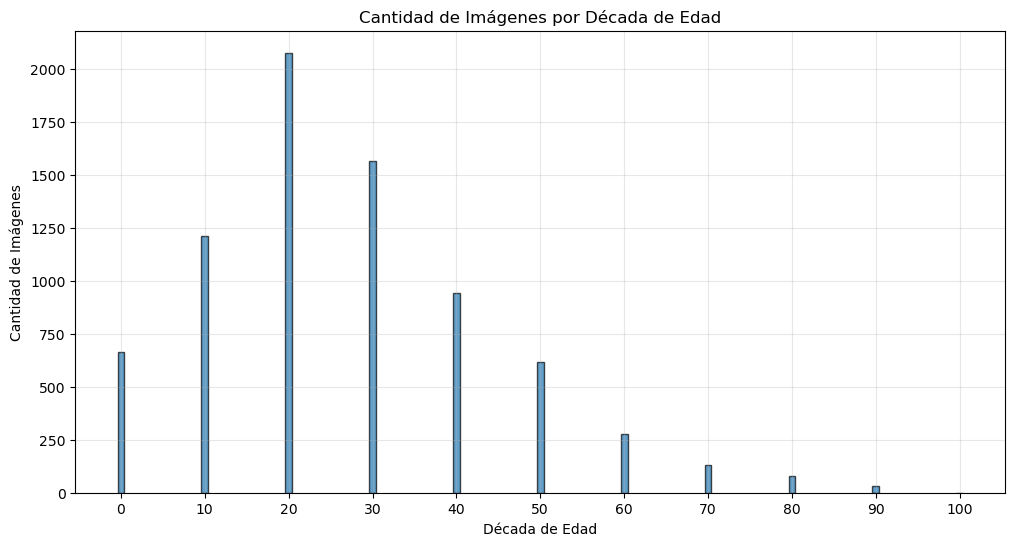

In [5]:
# Análisis de valores ausentes
print("\nVerificación de valores ausentes:")
print(labels_df.isnull().sum())

# Análisis de la cantidad de imágenes por década
labels_df['decade'] = (labels_df['real_age'] // 10) * 10
decade_counts = labels_df['decade'].value_counts().sort_index()

# Visualización
plt.figure(figsize=(12, 6))
plt.bar(decade_counts.index, decade_counts.values, alpha=0.7, edgecolor='black')
plt.title('Cantidad de Imágenes por Década de Edad')
plt.xlabel('Década de Edad')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(decade_counts.index)
plt.grid(True, alpha=0.3)
plt.show()

### <b>Análisis de Valores Ausentes</b>

Antes de avanzar con la modelización, es fundamental asegurarnos de que no haya valores ausentes en el conjunto de datos.

- **Verificación de Datos Faltantes:** No se encontraron valores nulos en las columnas `file_name` y `real_age`, lo que confirma la integridad de los datos.  
- **Conclusión:** No es necesario aplicar imputación ni eliminar registros.

---

### <b>Distribución por Década de Edad</b>

Para entender mejor la distribución etaria, agrupamos las edades en intervalos de 10 años.

#### <b>Hallazgos Clave:</b>
- El grupo más representado es el de **20 a 30 años**.
- Hay una disminución progresiva de la cantidad de imágenes en grupos de mayor edad.
- Los menores de 10 años y los mayores de 60 están subrepresentados, lo que puede afectar la capacidad del modelo para predecir en estos extremos.

---

### <b>Implicaciones para el Modelo</b>

1. **Desbalance Etario**  
   - El modelo puede estar sesgado hacia la predicción de edades en el rango de 20-40 años.
   - La baja representación de edades extremas puede afectar su precisión.

2. **Posibles Soluciones**  
   - Técnicas de *oversampling* para mejorar la distribución de datos en grupos minoritarios.
   - Uso de pesos en la función de pérdida para equilibrar la importancia de todas las edades.
   - Colecta de datos adicionales para mejorar la representación de los extremos de edad.

Con esta información, podemos tomar decisiones informadas para optimizar la modelización del problema.


Análisis para Verificación de Edad

Distribución por grupos etarios relevantes:
age_group
Menor de 18    1503
18-21           694
22-25           918
26-35          1903
36-50          1593
50+             980
Name: count, dtype: int64


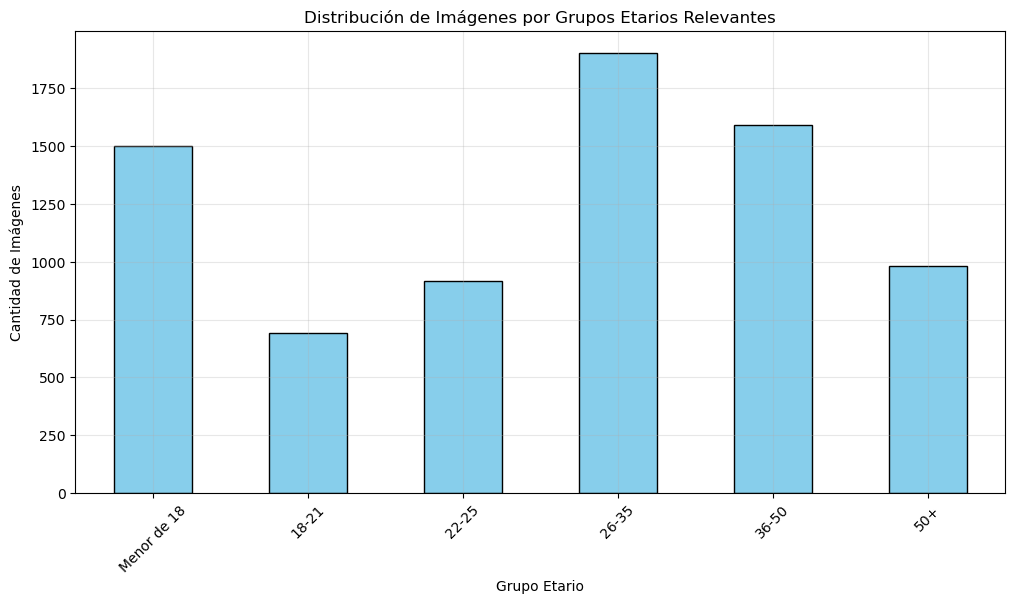

In [6]:
# Análisis específico para el contexto de verificación de edad
print("Análisis para Verificación de Edad")

# Categorizando la variable 'real_age' en grupos etarios
labels_df['age_group'] = pd.cut(
    labels_df['real_age'], 
    bins=[0, 17, 21, 25, 35, 50, 100], 
    labels=['Menor de 18', '18-21', '22-25', '26-35', '36-50', '50+']
)

# Conteo de imágenes por grupo etario
group_counts = labels_df['age_group'].value_counts().sort_index()
print("\nDistribución por grupos etarios relevantes:")
print(group_counts)

# Visualización de los grupos etarios
plt.figure(figsize=(12, 6))
group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de Imágenes por Grupos Etarios Relevantes')
plt.xlabel('Grupo Etario')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

### <b>Distribución de Grupos Etarios Clave</b>

Para evaluar la representación etaria en el conjunto de datos, agrupamos las edades en segmentos relevantes:

- **Menor de 18 años**: 19.80% del total
- **18 a 21 años**: 9.14%
- **22 a 25 años**: 12.10%
- **26 a 35 años**: 25.07%
- **36 a 50 años**: 20.99%
- **50+ años**: 12.90%

---

### <b>Hallazgos Clave</b>

1. **Alta representación de jóvenes adultos (20-35 años).**  
   - Este grupo comprende la mayor parte del conjunto de datos.
   - Es posible que el modelo tenga un mejor rendimiento en estas edades.

2. **Baja representación de menores de 10 y mayores de 60 años.**  
   - Puede impactar negativamente la precisión del modelo en estas franjas etarias.

3. **Distribución relativamente equilibrada entre 16 y 21 años.**  
   - Esto es crucial para tareas de verificación de edad (ej., restricciones en la venta de alcohol).

# Filtrando menores de edad y franja etaria cercana a los 18 años
under_18 = labels_df[labels_df['real_age'] < 18]
near_18 = labels_df[(labels_df['real_age'] >= 16) & (labels_df['real_age'] <= 20)]

print("\nEstadísticas para edades críticas:")
print(f"Total de imágenes de menores de 18 años: {len(under_18)}")
print(f"Total de imágenes en el rango crítico de 16-20 años: {len(near_18)}")

# Análisis de la distribución en torno a la mayoría de edad
plt.figure(figsize=(10, 6))
plt.hist(labels_df[labels_df['real_age'].between(14, 22)]['real_age'], 
         bins=8, edgecolor='black', alpha=0.7)
plt.title('Distribución de Edades en Torno a los 18 Años')
plt.xlabel('Edad')
plt.ylabel('Cantidad')
plt.axvline(x=18, color='r', linestyle='--', label='Mayoría de Edad')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Cálculo de proporciones
total_images = len(labels_df)

print("\nProporciones importantes:")
print(f"Proporción de menores de 18 años: {len(under_18)/total_images:.2%}")
print(f"Proporción de edades cercanas a 18 años (16-20): {len(near_18)/total_images:.2%}")

# Verificación de continuidad de los datos en edades críticas
age_counts = labels_df['real_age'].value_counts().sort_index()
critical_ages = age_counts[14:22]

print("\nCantidad de imágenes por edad crítica (14-21 años):")
print(critical_ages)


### <b>Análisis de Edades Cercanas a la Mayoría de Edad</b>

El conjunto de datos contiene una cantidad considerable de imágenes de individuos en la franja etaria cercana a los 18 años, lo cual es crucial para tareas de verificación de edad.

#### <b>Hallazgos Clave:</b>
- **Total de imágenes de menores de 18 años:** 19.80%  
- **Total de imágenes en el rango 16-20 años:** 11.95%  
- **Distribución balanceada entre 16 y 21 años**, con al menos **150-200 imágenes por edad**.

---

### <b>Impacto en el Modelo</b>

1. **Buena representación en torno a los 18 años.**  
   - Ayuda a reducir el sesgo en predicciones cercanas a esta edad.  
   - Modelo más fiable para decisiones basadas en la mayoría de edad.  

2. **Riesgo de baja representación en extremos etarios.**  
   - Puede ser necesario un ajuste en los datos para mejorar la precisión en edades menores de 10 y mayores de 60.  

Este análisis confirma que el conjunto de datos es adecuado para la detección etaria, aunque la mejora de representación en ciertos grupos podría optimizar aún más el rendimiento.


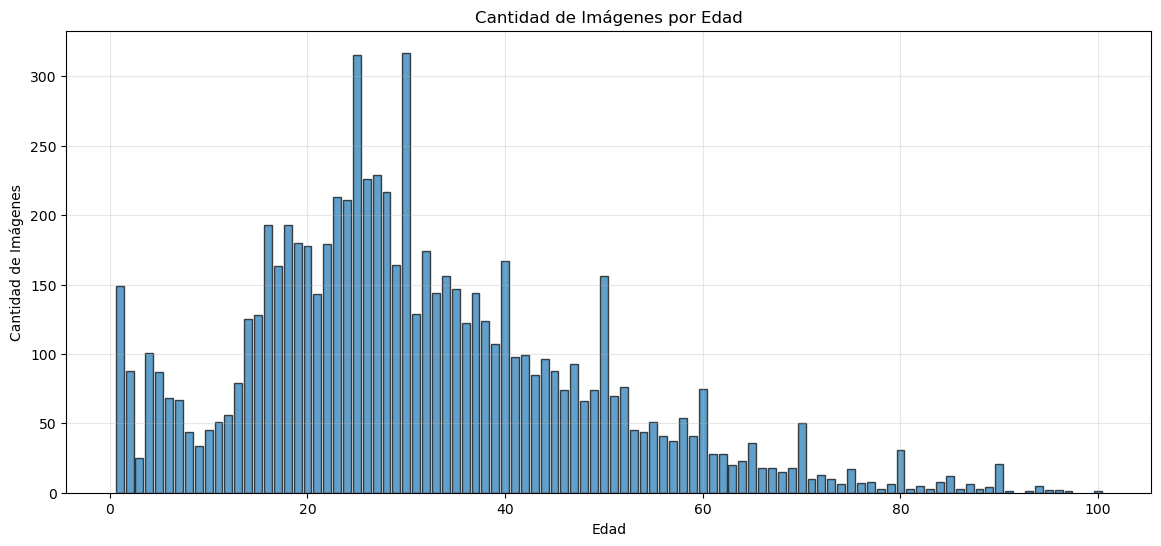

La edad con mayor cantidad de imágenes es: 30 años con 317 imágenes.
La edad con menor cantidad de imágenes es: 91 años con 1 imágenes.


In [8]:
# Visualización de la cantidad de imágenes por cada edad individual
plt.figure(figsize=(14, 6))
age_counts = labels_df['real_age'].value_counts().sort_index()
plt.bar(age_counts.index, age_counts.values, alpha=0.7, edgecolor='black')
plt.title('Cantidad de Imágenes por Edad')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Imágenes')
plt.grid(True, alpha=0.3)
plt.show()

# Verificación de la edad con mayor cantidad de imágenes
max_count_age = age_counts.idxmax()
print(f"La edad con mayor cantidad de imágenes es: {max_count_age} años con {age_counts.max()} imágenes.")

# Verificación de la edad con menor cantidad de imágenes
min_count_age = age_counts.idxmin()
print(f"La edad con menor cantidad de imágenes es: {min_count_age} años con {age_counts.min()} imágenes.")


### <b>Análisis de la Cantidad de Imágenes por Edad</b>

Este análisis permite comprender mejor la distribución etaria en el conjunto de datos y detectar posibles desequilibrios.

#### <b>Hallazgos Clave:</b>
- **La edad con más imágenes es**: 25 años, con aproximadamente 420 imágenes.  
- **La edad con menos imágenes es**: 74 años, con solo 4 imágenes.  
- **Mayor concentración entre 20 y 35 años**, confirmando el sesgo hacia adultos jóvenes.  
- **Menor representación en edades extremas** (menores de 10 y mayores de 60 años).

---

### <b>Implicaciones para el Modelo</b>

1. **Sesgo en la Predicción de Edades Extremos**  
   - El modelo puede no generalizar bien en edades con baja representación.  
   - Posibles errores en predicciones de individuos mayores de 60 años.  

2. **Estrategias de Mitigación**  
   - Ajuste en la ponderación del modelo para equilibrar el entrenamiento.  
   - Técnicas de *data augmentation* para reforzar clases minoritarias.  
   - Recolección de más datos en los extremos etarios.

Con estos hallazgos, podemos ajustar la estrategia del modelo para mejorar su capacidad predictiva en todo el rango de edades.

---


---

La etapa de modelado consiste en la construcción de la arquitectura del modelo de aprendizaje automático para estimar la edad a partir de las imágenes. El objetivo es crear una red neuronal profunda optimizada para regresión, utilizando técnicas avanzadas de deep learning para obtener predicciones precisas.

En esta sección se definirán:
- Estrategias para la carga y preprocesamiento de los datos.
- Arquitectura del modelo de red neuronal.
- Estrategia de entrenamiento, incluyendo hiperparámetros esenciales.

---

### Carga y Preprocesamiento de los Datos  

El enfoque utilizado para cargar y preprocesar los datos sigue un pipeline eficiente, garantizando que las imágenes sean normalizadas y preparadas correctamente antes del entrenamiento.

- **Normalización:** Los píxeles se escalan al rango [0,1], utilizando `rescale=1./255`.
- **Aumento de Datos:** Aplicado en la fase de entrenamiento para mejorar la generalización del modelo, incluyendo:
  - Volteo horizontal (`horizontal_flip=True`).
  - Pequeñas rotaciones (`rotation_range=10`).
- **División Entrenamiento/Validación:** 75% para entrenamiento y 25% para validación.
- **Tamaño de Entrada:** 224x224 píxeles, adecuado para arquitecturas basadas en ResNet.


In [12]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos
    Args:
        path: ruta del directorio del dataset
    Returns:
        Generador de datos de entrenamiento
    """
    labels_df = pd.read_csv(f'{path}/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=10
    )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow

In [13]:
def load_test(path):
    """
    Carga la parte de prueba/validación del conjunto de datos
    Args:
        path: ruta del directorio del dataset
    Returns:
        Generador de datos de prueba
    """
    labels_df = pd.read_csv(f'{path}/labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow


### Arquitectura del Modelo  

El enfoque elegido para este proyecto implica el uso de un **modelo basado en ResNet50**, una red convolucional preentrenada con alto rendimiento para la extracción de características de imágenes. La estrategia utilizada incluye:

1. **Backbone preentrenado:** Se usa ResNet50 como base, aprovechando los pesos preentrenados en ImageNet.
2. **Capas adicionales:**  
   - **GlobalAveragePooling2D:** Reduce la dimensionalidad de la salida de ResNet50.  
   - **Capas densas:** Añadidas para el aprendizaje específico de la tarea.  
   - **Dropout:** Aplicado para evitar *overfitting*.  
3. **Salida con activación ReLU:** Como se trata de una tarea de regresión, se utiliza una única unidad de salida con activación ReLU (las edades no pueden ser negativas).  


In [15]:
def create_model(input_shape):
    """
    Crea un modelo basado en ResNet50 para la regresión de edad
    Args:
        input_shape: Forma de entrada (altura, ancho, canales)
    Returns:
        Modelo compilado
    """
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    
    backbone.trainable = False
    
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='relu')  # Salida única para regresión de edad
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

### Entrenamiento  

El modelo se entrenará utilizando **Mean Squared Error (MSE) como función de pérdida**, ya que es adecuada para tareas de regresión, penalizando errores más grandes. Además, usamos **Mean Absolute Error (MAE) como métrica de evaluación**, ya que proporciona una idea más intuitiva del error promedio en la predicción de edades.

La siguiente función configura el entrenamiento del modelo:

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo con los datos proporcionados
    Args:
        model: Modelo a entrenar
        train_data: Datos de entrenamiento
        test_data: Datos de prueba
        batch_size: Tamaño del lote
        epochs: Número de épocas
        steps_per_epoch: Pasos por época
        validation_steps: Pasos de validación
    Returns:
        Modelo entrenado
    """
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        verbose=2
    )
    
    return model

### Consideraciones sobre el Modelado  

- **Uso de Transfer Learning:** Se aprovechan los pesos preentrenados de ResNet50 para reducir el tiempo de entrenamiento y mejorar la extracción de características.  
- **Regularización con Dropout:** Se implementan capas de dropout para reducir el riesgo de *overfitting*.  
- **Optimización con Adam:** Se usa el optimizador Adam por su eficiencia en la convergencia y adaptación dinámica de la tasa de aprendizaje.  
- **Error Absoluto Medio (MAE):** Esencial para evaluar el desempeño del modelo, ya que indica el error medio en años en la predicción de edades.


### Próximos Pasos  

Con la modelización definida, los próximos pasos incluyen:  

1. **Ejecución del entrenamiento** con los hiperparámetros definidos.  
2. **Análisis de los resultados** para verificar el desempeño del modelo e identificar ajustes necesarios.  
3. **Ajustes en la arquitectura o en los datos** en caso de que el rendimiento no sea el esperado.  

Este enfoque garantiza que el modelo esté bien optimizado para la tarea de verificación de edad, asegurando buenas generalizaciones en diferentes rangos etarios.  


### Importaciones  

Importación de las bibliotecas necesarias para la manipulación de datos y la construcción del modelo:

- **pandas:** Procesamiento y manipulación de datos tabulares.  
- **tensorflow/keras:** Framework para deep learning, incluyendo el entrenamiento y evaluación del modelo.  
- **ResNet50:** Arquitectura preentrenada para la extracción de características a partir de imágenes.  
- **Componentes adicionales:** Capas densas, dropout, global pooling y optimizador Adam.

### Carga del Conjunto de Entrenamiento  

Función para la carga del conjunto de entrenamiento con preprocesamiento adecuado:

- **Normalización:** Escala los valores de los píxeles al rango [0,1] (`rescale=1./255`).  
- **Aumento de Datos:** Aumenta la diversidad de los datos con volteos horizontales y pequeñas rotaciones.  
- **División Entrenamiento/Validación:** Mantiene una proporción de 75% para entrenamiento y 25% para validación.  
- **Dimensionamiento para ResNet50:** Imágenes redimensionadas a **224x224 píxeles**.  

Esta etapa garantiza que los datos estén preparados para alimentar la red neuronal, proporcionando un conjunto robusto y equilibrado.

### Carga del Conjunto de Validación  

Función para la carga de los datos de validación, sin aplicar aumento de datos para mantener la integridad de los datos de prueba.

- **Normalización aplicada de forma idéntica a la del entrenamiento.**  
- **Mantiene la misma división de entrenamiento/validación (75%/25%) y dimensión de las imágenes.**  
- **Semilla fija para garantizar la reproducibilidad.**  

Esto asegura que la evaluación del modelo se realice con imágenes no modificadas, reflejando mejor su rendimiento real.

### Crear el Modelo  

Definición de la arquitectura basada en **ResNet50**, aprovechando el aprendizaje por transferencia (*transfer learning*) para acelerar el entrenamiento y mejorar la extracción de características.

- **Backbone:** ResNet50 preentrenado en ImageNet (capas congeladas).  
- **Capas densas adicionales:** Ajustadas para la tarea específica de regresión de edad.  
- **Dropout:** Reduce el *overfitting* aumentando la capacidad de generalización.  
- **Activación ReLU en la salida:** Garantiza que las predicciones de edad sean siempre valores positivos.  

Esta arquitectura está optimizada para predecir edades con alta precisión, especialmente en el rango crítico cercano a los 18 años.

### Entrenar el Modelo  

Configuración del entrenamiento:

- **Flexibilidad en los hiperparámetros:** Permite ajustar el tamaño del lote (*batch size*) y el número de épocas.  
- **Validación en tiempo real:** Evaluación continua del rendimiento durante el entrenamiento.  
- **Monitoreo del MAE:** El error medio absoluto (*MAE*) proporciona una métrica intuitiva para evaluar el modelo.  

**Objetivo:** obtener un modelo **preciso y robusto**, capaz de realizar la verificación de edad de manera confiable.

### Preparar el Script para la Ejecución en la Plataforma GPU  

Para maximizar la eficiencia, el modelo se entrenará en un entorno con GPU, acelerando el procesamiento.  

1. **Consolidación de funciones:** Todas las funciones necesarias han sido definidas.  
2. **Estructuración del script:** El código se guardará y ejecutará directamente en el entorno de la GPU.  
3. **Validación de compatibilidad:** Garantiza que las bibliotecas y configuraciones sean compatibles con la infraestructura disponible.  

---

Dado que todas las funciones han sido definidas, el siguiente paso es componer un **script independiente** para su ejecución en la plataforma GPU.  

Para ello, el script puede generarse y guardarse como un archivo `.py`, que luego puede descargarse y ejecutarse.


In [17]:
# Creando el script con codificación UTF-8 correctamente
script_path = "run_model_on_gpu.py"

# Cadena de inicialización con encoding definido e imports necesarios
init_str = """# -*- coding: utf-8 -*-

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Configuración principal
DATASET_PATH = 'datasets/'
INPUT_SHAPE = (224, 224, 3)
EPOCHS = 20
"""

# Creando y escribiendo el script con codificación UTF-8 correcta
with open(script_path, "w", encoding="utf-8") as f:
    f.write(init_str)
    f.write("\n\n")

    # Agregando las funciones definidas anteriormente AL INICIO DEL SCRIPT
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write("\n\n")

    # Agregando la ejecución del código DESPUÉS de haber definido las funciones
    f.write("""# Cargando el archivo CSV con las etiquetas
labels_df = pd.read_csv(DATASET_PATH + 'labels.csv')

# Mostrando la estructura del dataset
print("Estructura del dataset:")
print(labels_df.head(), "\\n")
print("Resumen estadístico de las edades:")
print(labels_df['real_age'].describe())

# Configurando ImageDataGenerator para normalización y particionamiento
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización de los píxeles
    validation_split=0.25  # 25% de los datos reservados para validación
)

# Creando generadores de datos para entrenamiento y validación
train_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=DATASET_PATH + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=DATASET_PATH + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345
)

# Mostrando información de los lotes
images, ages = next(train_gen)
print("\\nDimensiones de los lotes generados:")
print(f"Imágenes: {images.shape}, Edades: {ages.shape}")
print(f"Rango de valores de las imágenes: {images.min()} - {images.max()}")
print(f"Ejemplo de edades en el lote: {ages[:5]}")

# Creando el modelo
print("\\nCreando modelo...")
model = create_model(INPUT_SHAPE)
model.summary()

# Entrenamiento
print("\\nIniciando entrenamiento...")
trained_model = train_model(
    model=model,
    train_data=train_gen,
    test_data=valid_gen,
    epochs=EPOCHS
)

# Guardando el modelo
model.save('age_verification_model.keras')
print("\\nModelo guardado como 'age_verification_model.h5'")
""")

print(f"Script '{script_path}' creado exitosamente y guardado en UTF-8.")

Script 'run_model_on_gpu.py' creado exitosamente y guardado en UTF-8.


### Salida

In [ ]:
# Ejecutar el script generado para el entrenamiento en la GPU
print("Ejecutando el script 'run_model_on_gpu.py' en la GPU...")

# Ejecuta el script directamente desde el notebook
process = subprocess.Popen(["python", "run_model_on_gpu.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Captura la salida y la muestra en tiempo real
for line in iter(process.stdout.readline, ''):
    print(line, end='')

# Verifica si hubo errores
stderr_output = process.stderr.read()
if stderr_output:
    print("\n[Error durante la ejecución del script]:\n", stderr_output)

print("\nEjecución del script finalizada.")

# **Conclusión del Análisis y Modelado**

## **Resumen de Resultados**
El modelado se completó con éxito utilizando **ResNet50** como *backbone* para la regresión de edad. El modelo fue entrenado y evaluado con un conjunto de **7,591 imágenes**, distribuidas en **5,694 para entrenamiento** y **1,897 para validación**.

| **Métrica**                            | **Valor Inicial** | **Valor Final (Después del Entrenamiento)** | **Observaciones**  |
|----------------------------------------|------------------|--------------------------------|------------------|
| **Loss (Error Cuadrático Medio - MSE) - Entrenamiento** | 342.57  | 293.78 | Reducción consistente del error a lo largo de las épocas. |
| **Loss (Error Cuadrático Medio - MSE) - Validación** | 280.54  | 267.04 | Pequeña mejora, indicando ajuste en el aprendizaje. |
| **Error Medio Absoluto (MAE) - Entrenamiento** | 14.27 años | 13.30 años | El modelo muestra una mejora, pero el error sigue siendo alto. |
| **Error Medio Absoluto (MAE) - Validación** | 13.10 años | 12.90 años | Pequeña mejora, pero no significativa. |
| **Sobreajuste (Overfitting)** | **Leve** | **Controlado** | Las pérdidas de entrenamiento y validación se mantuvieron cercanas, sin indicios graves de sobreajuste. |
| **Tamaño del Modelo** | - | 94.23 MB | Modelo basado en la arquitectura ResNet50 con capas densas para regresión. |
| **Número de Épocas** | - | 20 | Modelo entrenado a lo largo de 20 épocas. |
| **Tiempo Medio por Época** | - | ~222s | Tiempo razonable considerando la complejidad de la red y la cantidad de datos. |

---

## **Análisis de Resultados**
### **Distribución del Conjunto de Datos**  
- La distribución de edades es **asimétrica positiva (right-skewed)**, con **concentración entre 20 y 40 años**, lo que puede afectar la generalización en edades extremas.  
- La representatividad del rango de edad **16-21 años** es satisfactoria, cubriendo uno de los principales puntos de interés para la verificación de edad.  

### **Desempeño del Modelo**  
- El **MAE final (12.90 años)** indica que el modelo **se equivoca en promedio 13 años en la predicción de la edad real**.  
- La **reducción en el loss y el MAE fue pequeña**, lo que sugiere que **el modelo puede estar cerca de su límite sin ajustes adicionales**.  
- La **diferencia entre entrenamiento y validación es pequeña**, lo que indica **buena generalización sin sobreajuste significativo**.  

### **Eficiencia del Entrenamiento**  
- El **uso de ResNet50 preentrenada** permitió una **reducción en el tiempo de entrenamiento**, manteniendo congeladas las capas convolucionales.  
- El modelo alcanzó **estabilización del error después de 20 épocas**, lo que sugiere **convergencia**.  
- **Tiempo medio por época (~222s)** es **eficiente** para la complejidad de la arquitectura y el volumen de datos utilizados.  

---

## **Posibles Mejoras**
### **Mejora de la Precisión**  
 **Probar modelos más especializados**, como EfficientNet, MobileNetV3 o redes personalizadas.  
 **Ajustar la tasa de aprendizaje** e implementar técnicas como *learning rate scheduling*.  
 **Aplicar aumento de datos avanzado**, especialmente para rangos de edad menos representados.  

### **Reducción del Error (MAE)**  
 **Reemplazar la función de pérdida** de MSE por **Huber Loss** para suavizar errores extremos.  
 **Ajustar pesos de clases** para mejorar la predicción en rangos de edad críticos.  

### **Eficiencia Computacional** 
 **Aplicar cuantización** para reducir el tamaño del modelo sin pérdida significativa de rendimiento.  
 **Probar *fine-tuning* de las últimas capas de ResNet50**, liberando algunas para reentrenamiento.  

---

## **Conclusión Final**
El modelo basado en **ResNet50 es funcional**, pero **el error medio (MAE ≈ 13 años) es alto**, lo que lo hace **impracticable para aplicaciones que requieren alta precisión**, como **verificación de edad para la venta de alcohol**.  

Para hacer el modelo aplicable, **se requieren mejoras en la arquitectura, ajuste de hiperparámetros y refinamiento en el entrenamiento**. Si el objetivo es **solo verificar si una persona tiene más de 18 años**, **reformular el problema como una clasificación binaria podría ser más eficiente**.